<a href="https://colab.research.google.com/github/amitpanwarIndia/DLOps/blob/main/M22AIE202_DLOpsHomeAssignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

# IRIS dataset is loaded using sklearn.datasets
iris = load_iris()
X, y = iris.data, iris.target

# Splitting data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features using sklearn.preprocessing technique
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Now we have to create a custom DataLoader for PyTorch using torch library
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Defining the MLP model as requested in question and taught in class
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 5)
        self.fc2 = nn.Linear(5, 7)
        self.fc3 = nn.Linear(7, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        hidden_output = torch.relu(self.fc2(x))
        x = self.fc3(hidden_output)
        return x, hidden_output

# Initialize the model and Adam optimizer and Cross Entropy Loss
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Setting up TensorBoard writer
writer = SummaryWriter()

# training loop with hundres epochs with loss calculation
for epoch in range(100):
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output,_ = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # writting training loss
    writer.add_scalar('Loss/train', total_loss, epoch)

# evaluating the model on test data and hidden layer output is kept for generate t-SNE representation
with torch.no_grad():
    test_output, hidden_output  = model(torch.tensor(X_test, dtype=torch.float32))
    predicted_classes = torch.argmax(test_output, dim=1)
    accuracy = (predicted_classes == torch.tensor(y_test)).float().mean()

    # writting test accuracy
    writer.add_scalar('Accuracy/test', accuracy.item())

print(f"Calculated Test Accuracy: {accuracy.item():.4f}")


Calculated Test Accuracy: 0.9000


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

kf = KFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]

    # Train your model on X_fold_train, y_fold_train
    # Evaluate on X_fold_val, y_fold_val
    with torch.no_grad():
        test_output, _ = model(torch.tensor(X_fold_val, dtype=torch.float32))
        predicted_classes = torch.argmax(test_output, dim=1)
        accuracy=accuracy_score(y_fold_val, predicted_classes)
        accuracy_scores.append(accuracy)
        print(f"Accuracy: {accuracy:.4f}")
        writer.add_scalar('Accuracy/fold', accuracy)

        precision=precision_score(y_fold_val, predicted_classes, average='weighted')
        precision_scores.append(precision)
        print(f"Precision: {precision:.4f}")
        writer.add_scalar('Precision/fold', precision)

        recall=recall_score(y_fold_val, predicted_classes, average='weighted')
        recall_scores.append(recall)
        print(f"Recall: {recall:.4f}")
        writer.add_scalar('Recall/fold', recall)

#also calculating and printing Average accuracy, precision, recall
# Calculate average metrics across folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")

writer.add_scalar('Average/Accuracy', avg_accuracy)
writer.add_scalar('Average/Precision', avg_precision)
writer.add_scalar('Average/Recall', avg_recall)

Accuracy: 0.8333
Precision: 0.8333
Recall: 0.8333
Accuracy: 0.9167
Precision: 0.9583
Recall: 0.9167
Accuracy: 0.9167
Precision: 0.9286
Recall: 0.9167
Accuracy: 0.9167
Precision: 0.9333
Recall: 0.9167
Accuracy: 0.8333
Precision: 0.8333
Recall: 0.8333
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 0.5000
Precision: 0.3333
Recall: 0.5000
Accuracy: 0.7500
Precision: 0.7500
Recall: 0.7500
Accuracy: 0.9167
Precision: 0.9333
Recall: 0.9167
Accuracy: 0.7500
Precision: 0.8750
Recall: 0.7500
Average Accuracy: 0.8333
Average Precision: 0.8379
Average Recall: 0.8333


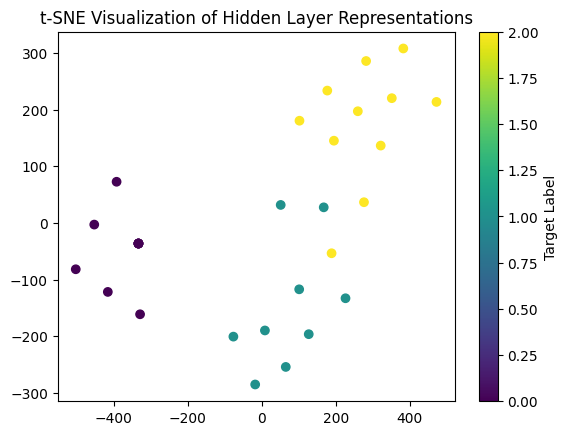

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#using hidden layer output generated on test dataset
hidden_layer_output = hidden_output.detach().numpy()
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(hidden_layer_output)

# Plotting t-SNE results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis')
plt.title("t-SNE Visualization of Hidden Layer Representations")
plt.colorbar(label='Target Label')
plt.show()

# Close the TensorBoard writer
writer.close()


In [ ]:
!tensorboard --logdir=runs

2024-03-17 07:36:41.490654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 07:36:41.490724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 07:36:41.492118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 07:36:42.952403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 